<h1> Комментарий тимлида </h1>

👋 **Приветствую, Алексей!** 

✨ Поздравляю с началом работы над финальным проектом!

Меня зовут Арсен Абдулин и я буду проверять твою работу. Предлагаю общаться на «ты», если не против=)

При проверке работ я пишу следующие комментарии:

<div class="alert alert-success">
<b>✔️ Зеленым цветом</b> отмечены удачные решения.</div>

<div class="alert alert-warning">
<b>⚠️ Желтым цветом</b> я отметил пункты, которые в следующий раз можно сделать по-другому. Одно-два таких замечания в проекте допускается, но если их много — проект следует доработать. </div>

<div class="alert alert-danger">
<b>🚫 Красным цветом</b> отмечены критические замечания, которые необходимо поправить, чтобы принять проект. </div>

Если какие-то моменты в задании для тебя были непонятны и у тебя есть ко мне вопросы — смело спрашивай 😊 Также ты можешь доработать места, где есть желтые комментарии в проекте (однако, это не обязательно).

Предлагаю работать в диалоге: если ты решишь что-то поменять по моим рекомендациям — пиши об этом (выбери для своих комментариев определенный цвет - так мне будет легче увидеть изменения). Пожалуйста не перемещай, не изменяй и не удаляй мои комментарии. Все это поможет сделать проверку твоего проекта оперативнее.

<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> Пример комментария. </div>

# Учебный Проект → «Прогнозирование оттока клиентов»

<div class="alert alert-info" role="alert" style="border-radius: 7px">
    <span style="font-size:0.7rem">Student's note 00</span>
    <p class="mb-0"><strong>Комментарий:</strong></p>
    <p>Арсен, здравствуй.</p>
    <p>Спасибо за <code>вводную консультацию</code>.</p>
</div>

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> Всегда пожалуйста 👍
    
</div>

## Задача проекта

>Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> Хорошо, когда есть небольшое описание проекта!
    
Можно также сформулировать цель работы
    
</div>

✅ название и описание проекта, цель проекта

## Цель проекта

Создать модель для поиска `классификации` пользователей, которые могут прекратить пользоваться услугами связи «Ниединогоразрыва.ком».

<hr>

In [1]:
import pandas as pd
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import phik

import matplotlib.cm as cm
from matplotlib.colors import ListedColormap


from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split

**Настроим вид графиков по+красоте** ✨

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
gr_wt_cmap = mpl.colors.LinearSegmentedColormap(
    name='forest_gradient',
    segmentdata = {
        'red':   [(0.0, 0.1333333, 0.1333333), (1.0, 0.1333333, 0.1333333)],
        'green': [(0.0, 0.5450980, 0.5450980), (1.0, 0.5450980, 0.5450980)],
        'blue':  [(0.0, 0.1333333, 0.1333333), (1.0, 0.1333333, 0.1333333)],
        'alpha': [(0.,0.,0.), (1.0,1.0,1.0)]
    },
    N=256,
)

In [4]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,
    
                "lines.color": '#EEEEEE',

                'text.color': '#EEEEEE',
    
                'font.family': 'sans-serif',
            }

In [5]:
# set max columns to none
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

**Константы:**

In [6]:
RANDOM_SEED = 270223
DPI_K = custom_params['figure.dpi'] / mpl.rcParams['figure.dpi']
PX = 1/custom_params['figure.dpi']
PY_CASE = re.compile(r'(?<!^)(?<![A-Z])(?=[A-Z])')
TEST_SIZE = 0.25
UPDATED_AT = np.datetime64('2020-02-01')

**Функции:**

In [7]:
def columns_w_na(data_df):
    col_nan = data_df.columns[
            data_df.isna().any()
        ].tolist()
    df_length = len(data_df.index)

    if len(col_nan) != 0:
        print('Колонки с NaN:')
        for col in col_nan:
            count_na = len(
                    data_df.loc[data_df[col].isna()].index
                )

            print(
                '{: .2%}'.format(count_na/df_length),
                end='\t→ '
            )
            print(col, end=' → ')
            print(count_na)
    else:
        print('Пропусков NaN в наборе данных нет.\n')

In [8]:
def baisic_df_info(data_df, title='Базовая информация'):
    print(title,  '→ о наборе данных:', end='\n\n')
    print('Дубликатов:',
             len(data_df.loc[data_df.duplicated()].index),
          end='\n\n'
     )
    
    columns_w_na(data_df)
    
    data_df.info()
    
    print()
    display(
        data_df.sample(5),
        data_df.describe(),
    )

In [9]:
def to_snake_case(df_columns, pattern=PY_CASE):
    to_return  = pd.Series(df_columns).apply(
            lambda c: re.sub(pattern, '_',  c ).lower()
        )
    
    return to_return

In [10]:
def to_px(size_px):
    px_density = int(
        round(
            size_px * PX * DPI_K
        )
    )
    return px_density

In [11]:
def plot_hist(data, title='Histogram', custom_params=custom_params):
    
    num_col = 2
    num_row = int(
            len(data.columns) / num_col
        ) + (len(data.columns) % num_col)
    
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=num_row,
            ncols=num_col,
            figsize=(
                to_px(960), to_px(960)),
            tight_layout=True
        )
        
        for n, col_name in enumerate(data.columns):
            ax_row = int(n/2)
            ax_col = n%2
            n_bins = len(data[col_name].unique())
                
            axs[ax_row, ax_col].hist(
                data[col_name],
                bins=n_bins,
                color='forestgreen'
            )
            axs[ax_row, ax_col].set_title(col_name)
        
        fig.suptitle(title, fontsize=16)
        
        if len(data.columns) % num_col:
            fig.delaxes(axs[-1, -1])

        plt.show()

<a id="compare_hist"></a>
[Apply compare_hist](#plot)

In [12]:
def compare_hist(data, title='Histogram', custom_params=custom_params):
    num_col = 1
    num_row = 2
    clmn_2_compare = list(data.columns)[0]
    
    data_stayed = total_df.loc[total_df['target'] == 0,
        clmn_2_compare
    ]
    data_exited = total_df.loc[total_df['target'] == 1,
        clmn_2_compare
    ]

    n_bins_st = len(data_stayed.unique())
    n_bins_ex = len(data_exited.unique())
                
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=num_row,
            ncols=num_col,
            figsize=(
                to_px(960), to_px(560)),
            tight_layout=True,
            sharex = True
        )
        axs[0].hist(
                data_stayed,
                bins=n_bins_st,
                color='forestgreen'
        )
        axs[0].set_title('остались')
        
        axs[1].hist(
                data_exited,
                bins=n_bins_ex,
                color='firebrick'
        )
        axs[1].set_title('ушли')

        fig.suptitle(title, fontsize=16)

        plt.show()

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> Отличная подготовка проекта! Здорово, что применяешь функции и глобальные настройки 👍
    
</div>

**Загружаем наборы данных**

In [13]:
try:
    contract_df = pd.read_csv(
            './datasets/contract.csv',
        )
    internet_df = pd.read_csv(
            './datasets/internet.csv',
        )
    personal_df = pd.read_csv(
            './datasets/personal.csv',
        )
    phone_df = pd.read_csv(
            './datasets/phone.csv',
        )
except FileNotFoundError:
    contract_df = pd.read_csv(
            '/datasets/final_provider/contract.csv',
        )
    internet_df = pd.read_csv(
            '/datasets/final_provider/internet.csv',
        )
    personal_df = pd.read_csv(
            '/datasets/final_provider/personal.csv',
        )
    phone_df = pd.read_csv(
            '/datasets/final_provider/phone.csv',
        )
    print('FYI datasets loaded via urls')

Сделаем названия столбцов по+красоте → `snake_case`  
Во имя Python:  
<img src="https://s3.dualstack.us-east-2.amazonaws.com/pythondotorg-assets/media/files/python-logo-only.svg" alt="Python logo" width="27px"/>

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> Согласен, правильное решение =)
    
</div>

In [14]:
contract_df.columns  = to_snake_case(contract_df.columns)
internet_df.columns  = to_snake_case(internet_df.columns)
personal_df.columns  = to_snake_case(personal_df.columns)
phone_df.columns  = to_snake_case(phone_df.columns)

In [15]:
baisic_df_info(contract_df, title='Контракты')

Контракты → о наборе данных:

Дубликатов: 0

Пропусков NaN в наборе данных нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB



,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
2194,2514-GINMM,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,79.50,79.5
565,5846-NEQVZ,2014-03-01,No,Two year,Yes,Credit card (automatic),70.85,4973.4
2913,6203-HBZPA,2015-10-01,No,Two year,No,Credit card (automatic),63.90,3334.95
5198,0643-OKLRP,2015-12-01,2019-11-01 00:00:00,Month-to-month,No,Electronic check,80.35,3825.85
3236,5402-HTOTQ,2018-10-01,No,Month-to-month,No,Electronic check,55.30,875.35


,monthly_charges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [16]:
contract_df.loc[
        contract_df['end_date'] == 'No',
        'end_date'
    ] = pd.NaT

contract_df['end_date'] = pd.to_datetime(
        contract_df['end_date']
    )

contract_df['end_date'].dt.date

print(
    'Ушедших пользователей',
    contract_df.loc[contract_df['end_date'].notnull(), 'customer_id'].count()
)

Ушедших пользователей 1869


In [17]:
contract_df['begin_date'] = pd.to_datetime(
        contract_df['begin_date']
    )

In [18]:
display(
    contract_df.loc[
        contract_df['total_charges'] == ' '
    ]
)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,


`total_charges` «пусто» только у тех пользователей, которые:
1. заключили договор на 1 год или 2 года
2. подключились в дату вгрузки данных `2020-02-01`

In [19]:
long_term = ['Two year', 'One year']

In [20]:
long_term_idxs = contract_df.loc[
        contract_df['type'].isin(long_term)
    ].index

In [21]:
print(len(long_term_idxs), 'пользователей заключили договор на год или два')

3168 пользователей заключили договор на год или два


In [22]:
display(
    contract_df.loc[
        long_term_idxs,
        (
            'begin_date',
            'end_date',
            'type',
            'monthly_charges',
            'total_charges'
        )
    ]
)

,begin_date,end_date,type,monthly_charges,total_charges
1,2017-04-01,NaT,One year,56.95,1889.5
3,2016-05-01,NaT,One year,42.30,1840.75
9,2014-12-01,NaT,One year,56.15,3487.95
11,2018-10-01,NaT,Two year,18.95,326.8
12,2015-04-01,NaT,One year,100.35,5681.1
...,...,...,...,...,...
7036,2019-02-01,NaT,One year,60.65,743.3
7037,2014-02-01,NaT,Two year,21.15,1419.4
7038,2018-02-01,NaT,One year,84.80,1990.5
7039,2014-02-01,NaT,One year,103.20,7362.9


In [23]:
print(contract_df.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


> За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года

In [24]:
print(
    'Поля ежемесячная плата и всего заплачено совпадают',
    len(contract_df.loc[
            contract_df['monthly_charges'] == contract_df['total_charges']
        ].index),
    'раз'
)

Поля ежемесячная плата и всего заплачено совпадают 0 раз


Предположим что **«Ниединогоразрыва.ком»** использует **предоплатную** систему расчета.  
Тогда прировняем пустые `total_charges` к `monthly_charges`.

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> Здорово, что обратил внимание на пустые строки в признаке TotalCharges! Заполнение пропусков выполнено успешно
    
</div>

In [25]:
contract_df.loc[
            contract_df['total_charges'] == ' ',
            'total_charges'
    ] = contract_df.loc[
            contract_df['total_charges'] == ' ',
            'monthly_charges'
    ]

In [26]:
contract_df.loc[:, 
        ['monthly_charges', 'total_charges' ]
    ] = contract_df.loc[:, 
        ['monthly_charges', 'total_charges' ]].astype({
            'monthly_charges': 'float16',
             'total_charges': 'float32' 
        })

/tmp/ipykernel_10806/4100139373.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  contract_df.loc[:,


In [27]:
display(
    contract_df.sample(5)
)
contract_df.info()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
6169,4847-QNOKA,2019-12-01,2020-01-01,Month-to-month,Yes,Bank transfer (automatic),44.90625,44.900002
3283,1085-LDWAM,2014-05-01,NaT,One year,Yes,Credit card (automatic),20.34375,1442.650024
5839,2077-MPJQO,2019-07-01,NaT,Month-to-month,Yes,Electronic check,75.37500,533.049988
6689,8561-NMTBD,2014-07-01,NaT,One year,Yes,Credit card (automatic),112.37500,7388.450195
4449,2001-EWBQU,2015-02-01,NaT,Two year,No,Electronic check,104.68750,6333.799805


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float16       
 7   total_charges      7043 non-null   float32       
dtypes: datetime64[ns](2), float16(1), float32(1), object(4)
memory usage: 371.5+ KB


In [28]:
baisic_df_info(internet_df, 'Интернет')

Интернет → о наборе данных:

Дубликатов: 0

Пропусков NaN в наборе данных нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB



,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
3180,1629-DQQVB,DSL,Yes,No,No,No,No,No
4814,2378-HTWFW,Fiber optic,Yes,No,No,No,No,Yes
3383,4013-TLDHQ,Fiber optic,No,Yes,Yes,No,No,No
5426,5996-EBTKM,DSL,No,No,Yes,Yes,No,Yes
3379,1455-ESIQH,Fiber optic,No,No,No,No,Yes,Yes


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [29]:
baisic_df_info(personal_df, title='Пользователи')

Пользователи → о наборе данных:

Дубликатов: 0

Пропусков NaN в наборе данных нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB



,customer_id,gender,senior_citizen,partner,dependents
3056,0263-FJTQO,Male,0,Yes,Yes
4450,4925-LMHOK,Male,0,No,No
2223,8182-BJDSI,Female,0,No,No
6010,3460-TJBWI,Male,0,Yes,Yes
103,5386-THSLQ,Female,1,Yes,No


,senior_citizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [30]:
baisic_df_info(phone_df, title='Телефония')

Телефония → о наборе данных:

Дубликатов: 0

Пропусков NaN в наборе данных нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB



,customer_id,multiple_lines
2966,6778-EICRF,Yes
1958,1391-UBDAR,No
1835,6845-RGTYS,Yes
284,6745-JEFZB,Yes
1030,3156-QLHBO,No


,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


✅ все датафреймы должны быть исследованы (методы describe(), info(), можно добавить графики)

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> Предварительный анализ данных выполнен успешно!
    
</div>

## План проекта

1. Анализируем наборы данных  
    1.1. Предобрабатываем данные
2. Выбираем необходимые `features`  
    2.1. Смотрим на корреляции  
    2.2. Включаем логику  
    2.3. Создаём признаки  
    2.4. Создаём `targets` из `'end_date'`  
    2.5. Объединяем наборы данных в один
3. Тестируем разные модели  
    3.0. Делим набор данных на тестовую и тренировочную выборки  
    3.1. `RandomForestClassifier`  
    3.2. `LogisticRegression`  
    3.3. `CatBoostClassifier`  
4. Тестируем лучшую модель на кроссвалидации модель
5. Пишем выводы


✅ содержание (план) проекта: здесь нужно привести структуру проекта, т.е. основные пункты и подпункты. План должен быть достаточно подробным, обычном минимум 4-5 основных пунктов с подпунктами.

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> План работ последовательный и понятный, все хорошо! 
    
Единственное, в работе нужно обязательно сделать исследовательский анализ данных (диаграммы) после генерации новых признаков и целевой переменной. Возможно ты и так планировал, но в плане не отражено =)
    
Перед EDA нужно объединить таблицы и заполнить пропуски
    
</div>

### Вопросы

1. Предоплатная ли система расчётов у **«Ниединогоразрыва.ком»?**
2. Может ли нейронная сеть быть классификатором, какая, что почитать, пожалуйста?
3. Какие действия = пункты плана можно еще выполнить?
4. Где раздобыть еще выборку по ушедшим абонентам; Могут ли **«Ниединогоразрыва.ком»** предоставить еще информацию?)
5. Есть ли ещё что+то важное что стоит учесть до начала действий, пожалуйста?

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> По твоим вопросам:
    
1. Можно считать, что есть предоплата
    
2. В принципе логистическая регрессия — это простейшая нейронная сеть =) В данном проекте не требуется классификация с помощью нейронки, но ты конечно можешь попробовать, если есть опыт. В целом для решения аналитических задач по классификации в настоящее время используют модели бустингов, именно они дают хорошие результаты. 
    
Нейронки больше используются в компьютерном зрении, анализе текстов. 
    
Неплохой пример с решением задачи классификации с помощью нейросети:
    
https://www.kaggle.com/code/shrutimechlearn/deep-tutorial-1-ann-and-classification
    
3. Сделать исследовательский анализ (построить графики) для ушедших и оставшихся клиентов. Скорее всего признаки, например ежемесячные платежи, будут отличаться.
    
Кодирование признаков делаем после деления на выборки, также масштабирование (требуется для линейных моделей)
    
4. Пока это все, что есть )) Не забудь учесть дисбаланс классов при обучении моделей. Можно конечно использовать библиотеку imblearn для балансировки, но тогда нужен pipeline
    
5. Ну вроде бы все, главное чтобы не было утечки данных из теста в обучение. Качество моделей проверяем на кросс-валидации.
    
Если что, пиши в Пачке по всем вопросам
    
</div>

✅ вопросы и комментарии к тимлиду (если вопросов нет, нужно явно про это написать, иначе проект будет возвращен для получения возможных вопросов студента)

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> План работ принят, можно приступать к основному проекту. 
    
Пожалуйста сохрани наши с тобой комментарии, а проект продолжай делать в этом же документе, успехов!
    
</div>

<hr>

## Основная Часть Проекта

Объединим наборы данных в один

> Joining multiple DataFrames only supported for joining on index  

Поэтому индексами назначим `customer_id`

In [31]:
contract_df.set_index('customer_id', drop=True, inplace=True)
internet_df.set_index('customer_id', drop=True, inplace=True)
personal_df.set_index('customer_id', drop=True, inplace=True)
phone_df.set_index('customer_id', drop=True, inplace=True)

In [32]:
total_df = personal_df.join(
        [contract_df, internet_df, phone_df],
        # on='customer_id',
        how='left',
        sort=False,
    )

In [33]:
display(list(total_df.columns))

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'begin_date',
 'end_date',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [34]:
cat_features = [
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'type',
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'multiple_lines',
]

### Исследовательский Анализ Данных

### Предобработка Данных

In [35]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gender             7043 non-null   object        
 1   senior_citizen     7043 non-null   int64         
 2   partner            7043 non-null   object        
 3   dependents         7043 non-null   object        
 4   begin_date         7043 non-null   datetime64[ns]
 5   end_date           1869 non-null   datetime64[ns]
 6   type               7043 non-null   object        
 7   paperless_billing  7043 non-null   object        
 8   payment_method     7043 non-null   object        
 9   monthly_charges    7043 non-null   float16       
 10  total_charges      7043 non-null   float32       
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

In [36]:
for column in cat_features:
    print(
        column,
        list(total_df[column].unique()),
        sep='\n\t',
        end='\n'*2
    )

gender
	['Female', 'Male']

senior_citizen
	[0, 1]

partner
	['Yes', 'No']

dependents
	['No', 'Yes']

type
	['Month-to-month', 'One year', 'Two year']

paperless_billing
	['Yes', 'No']

payment_method
	['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']

internet_service
	['DSL', 'Fiber optic', nan]

online_security
	['No', 'Yes', nan]

online_backup
	['Yes', 'No', nan]

device_protection
	['No', 'Yes', nan]

tech_support
	['No', 'Yes', nan]

streaming_tv
	['No', 'Yes', nan]

streaming_movies
	['No', 'Yes', nan]

multiple_lines
	[nan, 'No', 'Yes']



In [37]:
cstmrs_without_phone = total_df.loc[
        total_df['multiple_lines'].isna()
    ].index

display(
    total_df.loc[
        cstmrs_without_phone,
        'internet_service'
    ].unique()
)
print(len(cstmrs_without_phone), 'абонента не пользуются телефонией')

array(['DSL'], dtype=object)

682 абонента не пользуются телефонией


In [38]:
total_df.loc[
        cstmrs_without_phone,
        'multiple_lines'
    ] = 'without phone'

In [39]:
cstmrs_without_internet = total_df.loc[
        total_df['internet_service'].isna()
    ].index

display(
    total_df.loc[
        cstmrs_without_internet,
        'multiple_lines'
    ].unique()
)
print(len(cstmrs_without_internet), 'абонента не пользуются интернетом')

array(['No', 'Yes'], dtype=object)

1526 абонента не пользуются интернетом


In [40]:
total_df.loc[
        cstmrs_without_internet,
        'internet_service'
    ] = 'without internet'

In [41]:
display(list(internet_df.columns))

['internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies']

In [42]:
add_internet_services = [
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies'
]

Об абонетнах, которые не пользуются интернетом мы знаем по `internet_service == 'without internet'`. Поэтому для таких пользователей заполним `NaN` в дополнительных интернет услугах как `No`. Чтобы не раздувать количество признаков.

In [43]:
for add_i_serv in add_internet_services:
    total_df.loc[
        cstmrs_without_internet,
        add_i_serv
    ] = 'No'

In [44]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gender             7043 non-null   object        
 1   senior_citizen     7043 non-null   int64         
 2   partner            7043 non-null   object        
 3   dependents         7043 non-null   object        
 4   begin_date         7043 non-null   datetime64[ns]
 5   end_date           1869 non-null   datetime64[ns]
 6   type               7043 non-null   object        
 7   paperless_billing  7043 non-null   object        
 8   payment_method     7043 non-null   object        
 9   monthly_charges    7043 non-null   float16       
 10  total_charges      7043 non-null   float32       
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

Создадим новый признак → `months_of_usage` → колличество месяцев которое абонент пользуется услугами **«Ниединогоразрыва.ком»**

In [45]:
total_df['months_of_usage'] = 0

In [46]:
total_df.loc[
        total_df['end_date'].notna(),
        'months_of_usage'
    ] = (
            total_df.loc[
                total_df['end_date'].notna(),
                'end_date'
            ]
            - total_df.loc[
                total_df['end_date'].notna(),
                'begin_date'
            ]
        ) / np.timedelta64(1, 'M')

In [47]:
total_df.loc[
        total_df['end_date'].isna(),
        'months_of_usage'
    ] = (
            UPDATED_AT
            - total_df.loc[
                total_df['end_date'].isna(),
                'begin_date'
            ]
        ) / np.timedelta64(1, 'M')

In [48]:
display(
    total_df['months_of_usage'].describe()
)

count    7043.000000
mean       32.394790
std        24.561912
min         0.000000
25%         8.969383
50%        29.010863
75%        55.064786
max        71.985051
Name: months_of_usage, dtype: float64

Создадим признак → `target`

In [49]:
# total_df['target'] = 0
total_df['target'] = total_df['end_date'].apply(
        lambda ed: 1 if pd.notna(ed) else 0
    )

In [50]:
display(total_df['target'].describe())

count    7043.000000
mean        0.265370
std         0.441561
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

Присвоим категориальным признакам тип `category`

In [51]:
total_df.loc[: , cat_features] = total_df.loc[: ,
        cat_features
     ].astype({
        'gender': 'category',
        'senior_citizen': 'category',
        'partner': 'category',
        'dependents': 'category',
        # 'begin_date': '',
        # 'end_date': '',
        'type': 'category',
        'paperless_billing': 'category',
        'payment_method': 'category',
        # 'monthly_charges': '',
        # 'total_charges': '',
        'internet_service': 'category',
        'online_security': 'category',
        'online_backup': 'category',
        'device_protection': 'category',
        'tech_support': 'category',
        'streaming_tv': 'category',
        'streaming_movies': 'category',
        'multiple_lines': 'category'
    })

/tmp/ipykernel_10806/1168093265.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  total_df.loc[: , cat_features] = total_df.loc[: ,


In [52]:
total_df.loc[: , ['months_of_usage','target']] = total_df.loc[: ,
        ['months_of_usage','target']].astype({
            'months_of_usage': 'float16',
            'target': 'category'
        })

/tmp/ipykernel_10806/4154138686.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  total_df.loc[: , ['months_of_usage','target']] = total_df.loc[: ,


In [53]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gender             7043 non-null   category      
 1   senior_citizen     7043 non-null   category      
 2   partner            7043 non-null   category      
 3   dependents         7043 non-null   category      
 4   begin_date         7043 non-null   datetime64[ns]
 5   end_date           1869 non-null   datetime64[ns]
 6   type               7043 non-null   category      
 7   paperless_billing  7043 non-null   category      
 8   payment_method     7043 non-null   category      
 9   monthly_charges    7043 non-null   float16       
 10  total_charges      7043 non-null   float32       
 11  internet_service   7043 non-null   category      
 12  online_security    7043 non-null   category      
 13  online_backup      7043 non-null   category      
 14

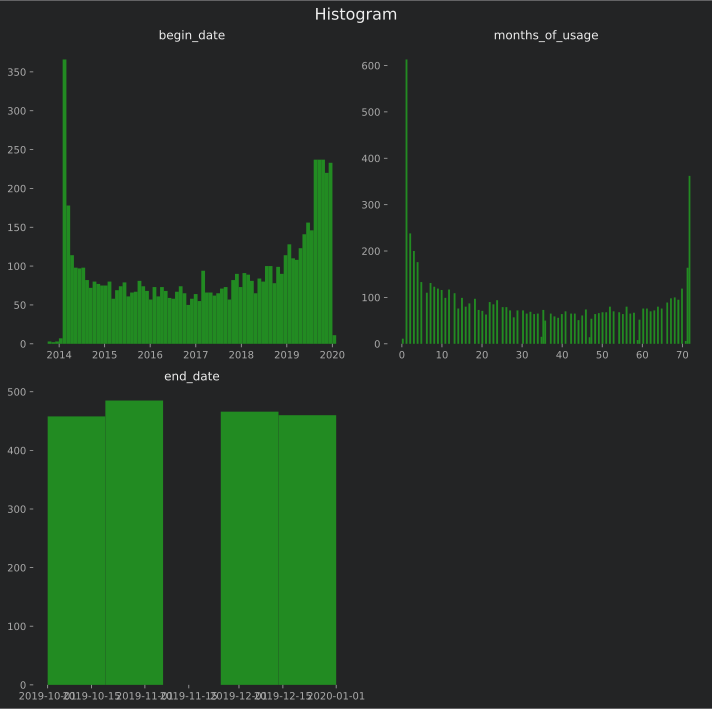

In [54]:
plot_hist(total_df.loc[: , [
        'begin_date',
        'months_of_usage',
        'end_date'
    ]])

Очень странно что только 4 даты когда абоненты прекратили пользоваться услугами…

In [55]:
display(
    total_df['end_date'].describe(datetime_is_numeric=True)
)

count                             1869
mean     2019-11-15 21:31:18.009630976
min                2019-10-01 00:00:00
25%                2019-11-01 00:00:00
50%                2019-11-01 00:00:00
75%                2019-12-01 00:00:00
max                2020-01-01 00:00:00
Name: end_date, dtype: object

In [56]:
print(len(total_df['end_date'].unique()))

5


In [57]:
print(len(contract_df['end_date'].unique()))

5


In [58]:
print(total_df['end_date'].unique())

[                          'NaT' '2019-12-01T00:00:00.000000000'
 '2019-11-01T00:00:00.000000000' '2019-10-01T00:00:00.000000000'
 '2020-01-01T00:00:00.000000000']


Для ползователей, которые закончили пользоваться услугами

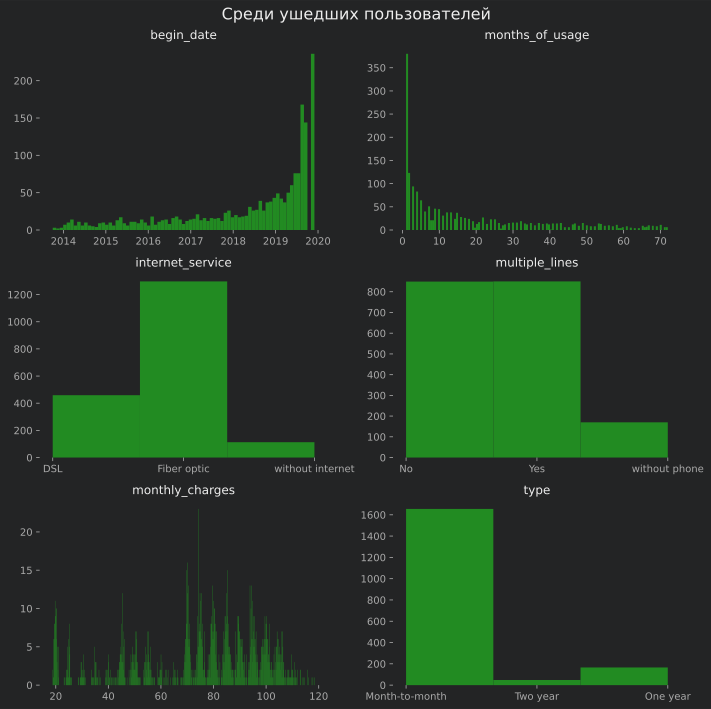

In [59]:
plot_hist(total_df.loc[total_df['target'] == 1, [
        'begin_date',
        'months_of_usage',
        'internet_service',
        'multiple_lines',
        'monthly_charges',
        'type'
    ]],
    title='Среди ушедших пользователей'
         )

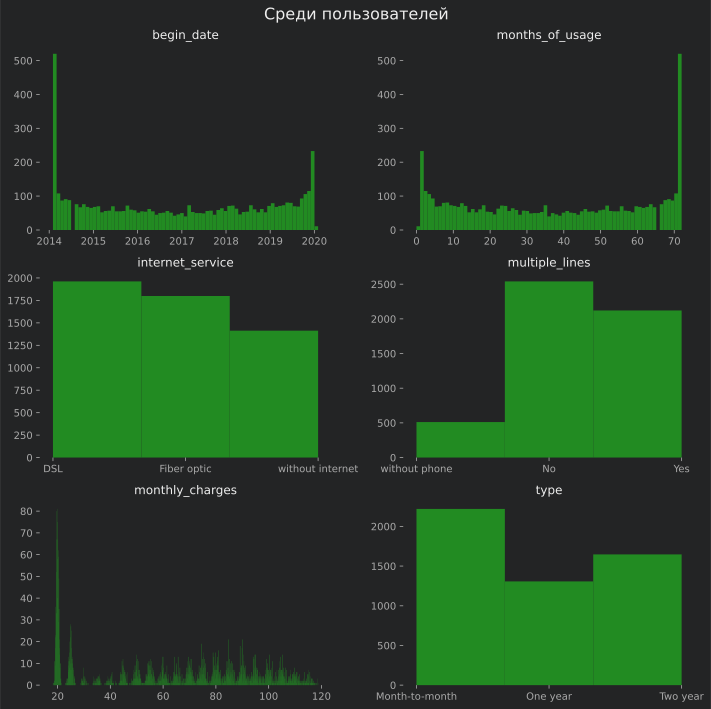

In [60]:
plot_hist(total_df.loc[total_df['target'] == 0, [
        'begin_date',
        'months_of_usage',
        'internet_service',
        'multiple_lines',
        'monthly_charges',
        'type'
    ]],
    title='Среди пользователей'
         )

<a id="plot"></a>
[def compare_hist](#compare_hist)

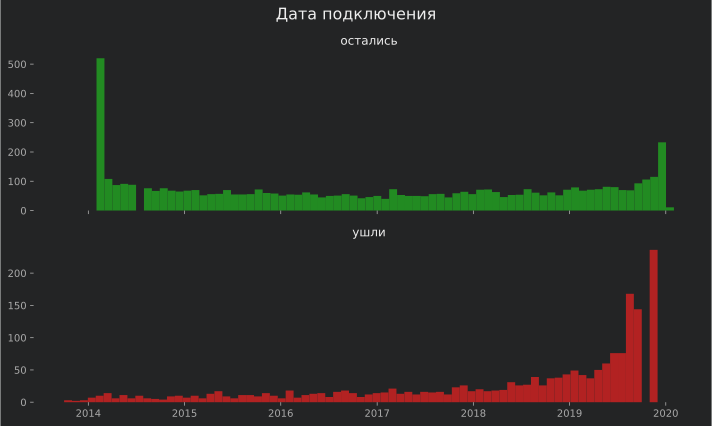

In [61]:
compare_hist(
    total_df.loc[: , ['begin_date', 'target']],
    title='Дата подключения'
)

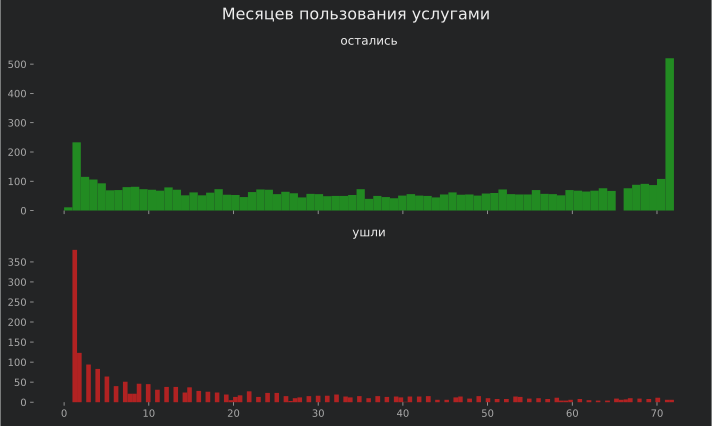

In [62]:
compare_hist(
    total_df.loc[: , ['months_of_usage', 'target']],
    title='Месяцев пользования услугами'
)

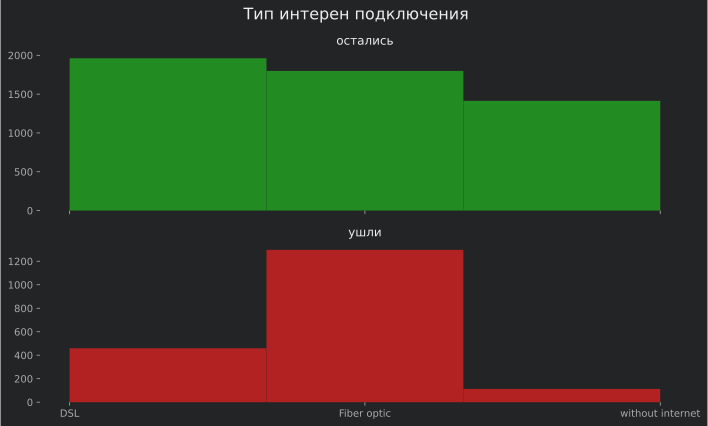

In [63]:
compare_hist(
    total_df.loc[: , ['internet_service', 'target']],
    title='Тип интерен подключения'
)

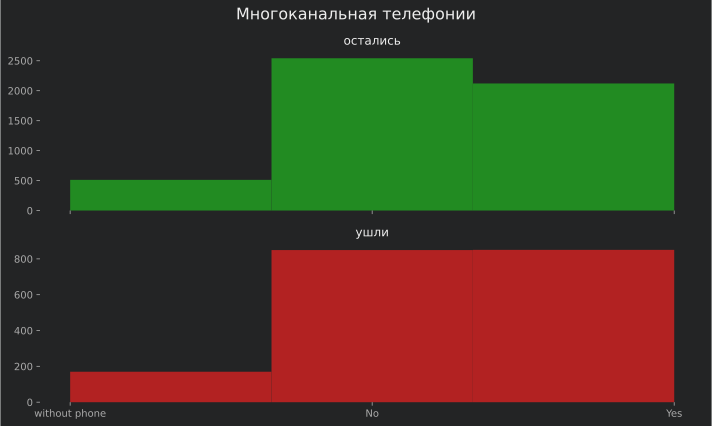

In [64]:
compare_hist(
    total_df.loc[: , ['multiple_lines', 'target']],
    title='Многоканальная телефонии'
)

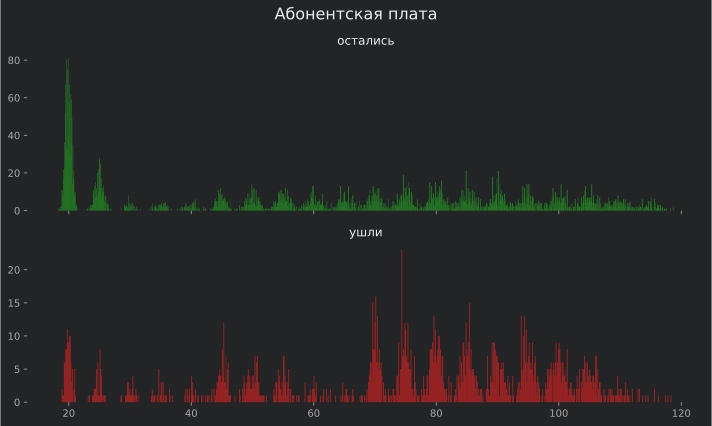

In [65]:
compare_hist(
    total_df.loc[: , ['monthly_charges', 'target']],
    title='Абонентская плата'
)

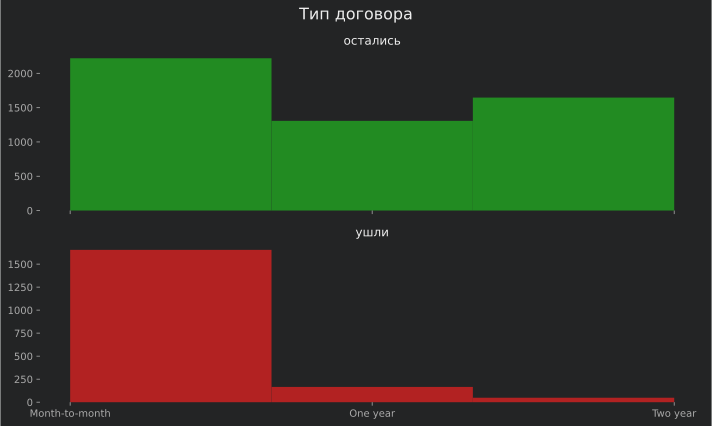

In [66]:
compare_hist(
    total_df.loc[: , ['type', 'target']],
    title='Тип договора'
)

Даты на чала и окончания пользования услугами использовать для обучения модели не будем. Потомучто есть производный признак количество месяцев пользования..

In [67]:
total_df.drop(columns=['begin_date', 'end_date'], inplace=True)

In [68]:
phik_mtrx = total_df.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'months_of_usage']


In [69]:
display(phik_mtrx)

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,months_of_usage,target
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008172,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.000000,1.000000,0.016992,0.324576,0.086231,0.242133,0.292725,0.304696,0.148755,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.087925,0.028663,0.233432
partner,0.000000,0.016992,1.000000,0.652122,0.179736,0.013218,0.243008,0.202947,0.422402,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.086249,0.491658,0.232930
dependents,0.000000,0.324576,0.652122,1.000000,0.147680,0.172593,0.224903,0.183996,0.114304,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.011198,0.212209,0.253936
type,0.000000,0.086231,0.179736,0.147680,1.000000,0.106860,0.277462,0.388065,0.505287,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.244410,0.664660,0.251639
paperless_billing,0.000000,0.242133,0.013218,0.172593,0.106860,1.000000,0.370495,0.467810,0.205901,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.099953,0.000000,0.295754
payment_method,0.000000,0.292725,0.243008,0.224903,0.277462,0.370495,1.000000,0.399615,0.350460,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.174849,0.375115,0.449125
monthly_charges,0.008172,0.304696,0.202947,0.183996,0.388065,0.467810,0.399615,1.000000,0.762534,0.918976,0.551465,0.629611,0.667304,0.576166,0.835334,0.833281,0.710095,0.410911,0.359955
total_charges,0.000000,0.148755,0.422402,0.114304,0.505287,0.205901,0.350460,0.762534,1.000000,0.508171,0.544407,0.655082,0.671222,0.565910,0.659672,0.666350,0.493551,0.842175,0.279152
internet_service,0.000000,0.160702,0.000000,0.108463,0.505187,0.231438,0.323886,0.918976,0.508171,1.000000,0.241421,0.233602,0.232916,0.239663,0.272818,0.272782,0.739808,0.019357,0.196202


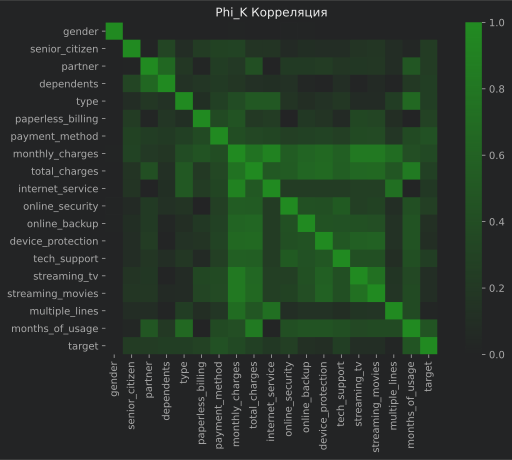

In [70]:
with mpl.rc_context(custom_params):
    
    plt.imshow(phik_mtrx, cmap=gr_wt_cmap)
    plt.xticks(rotation=90)
    plt.xticks(np.arange(len(total_df.columns)), total_df.columns)
    plt.yticks(np.arange(len(total_df.columns)), total_df.columns)
    plt.colorbar().outline.set_visible(False)
    plt.title('Phi_K Корреляция')
    plt.show()

In [71]:
for column in phik_mtrx.columns:
    idxs = phik_mtrx.loc[
            (phik_mtrx[column] <  1)
            & (phik_mtrx[column] > 0.7)
        ].index
    
    if len(idxs) > 0:
        print('Для', column)
        print('\t',
            idxs.values
        )

Для monthly_charges
	 ['total_charges' 'internet_service' 'streaming_tv' 'streaming_movies'
 'multiple_lines']
Для total_charges
	 ['monthly_charges' 'months_of_usage']
Для internet_service
	 ['monthly_charges' 'multiple_lines']
Для streaming_tv
	 ['monthly_charges' 'streaming_movies']
Для streaming_movies
	 ['monthly_charges' 'streaming_tv']
Для multiple_lines
	 ['monthly_charges' 'internet_service']
Для months_of_usage
	 ['total_charges']


Корреляции:
* `gender` → не коррелирует с `target`
* `months_of_usage` → `total_charges` 0.842175, это и понятно)
* `internet_service` → `monthly_charges` 0.918976

In [72]:
total_df.drop(columns=['gender'], inplace=True)

In [73]:
features = total_df.drop(columns='target')
targets = total_df['target'].values

In [74]:
print(
    features.shape,
    targets.shape
     )

(7043, 17) (7043,)


In [78]:
features_train, features_test, targets_train, targets_test = train_test_split(
        features,
        targets,
        test_size=TEST_SIZE,
        random_state=RANDOM_SEED,
        shuffle=True,
        stratify=None
    )

In [81]:
cat_model = CatBoostClassifier(
        iterations=2,
        depth=2,
        # learning_rate=1,
        eval_metric='AUC',
        cat_features=cat_features,
        random_seed=RANDOM_SEED,
        verbose=True)

In [82]:
cat_model.fit(features_train, targets_train)

CatBoostError: Invalid label type=<class 'pandas.core.arrays.categorical.Categorical'>: must be array like.

<hr>

🔗 [Exploratory Data Analysis with Pandas Profiling](https://towardsdatascience.com/exploratory-data-analysis-with-pandas-profiling-de3aae2ddff3)

<hr>

## Отчет

to be continued…

<hr>

>✍️ Основные тезисы вводной консультации:
> - фиксируем параметр RANDOM_STATE = 270223 (дата начала финального спринта);
> - дедлайн сдачи отчета 11 марта 23:59 по мск (вторая суббота);
> - размер тестовой выборки: test_size = 0.25 (строго!!!);
> - рекомендуется использовать OneHotEncoder для кодирования категориальных признаков. Кодируем после разделения на train и test, чтобы не было утечки в данных;
> - если при кодировании используется get_dummies, то нужно сравнить списки получившихся признаков (должно быть полное совпадение);
> - помимо основной части, в проекте нужно сделать визуализацию графиков, исследовать корреляцию признаков. Для числовых признаков используем корреляцию Спирмена, для категориальных - Крамера. Можно применять инструмент фи-корреляции для смешанного набора признаков (библиотека phik);
> - для линейных моделей нужно масштабировать числовые признаки;
> - про баланс классов: Upsampling использовать не нужно (!!!), лучше используйте балансировку классов внутри модели;
> - на выборке test проверяется только одна лучшая модель, а сравнение моделей делаем с использованием кросс-валидации.
  
© Арсен Абдулин